In [1]:
import numpy as np
import cv2 as cv
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [2]:
cv.__version__

'4.5.1'

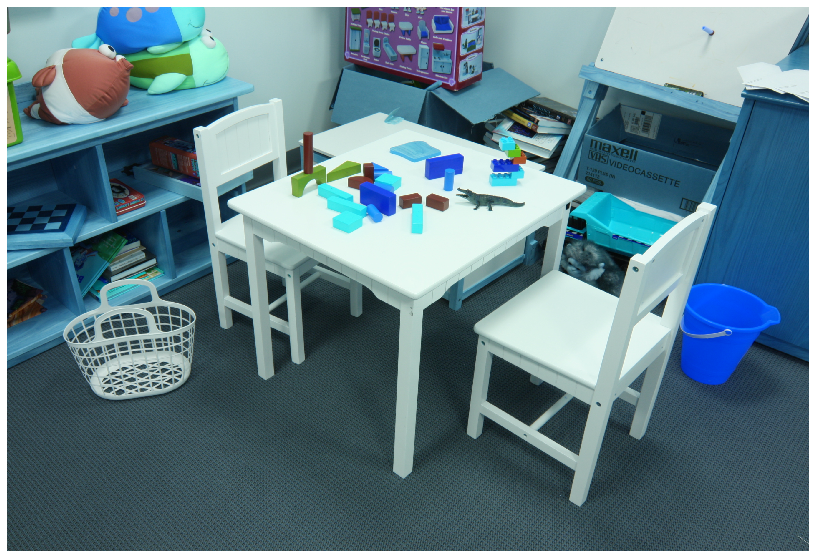

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)

imgL = cv.imread('data/Middlebury/Playtable-perfect/im0.png')
imgR = cv.imread('data/Middlebury/Playtable-perfect/im1.png')
# imgL = cv.imread('data/Middlebury/Jadeplant-perfect/im0.png')
# imgR = cv.imread('data/Middlebury/Jadeplant-perfect/im1.png')

plt.axis('off')

plt.imshow(imgL)
plt.show()

## Adds left padding

In [4]:
imgL = cv.copyMakeBorder(imgL,0,0,288,0,cv.BORDER_CONSTANT)
imgR = cv.copyMakeBorder(imgR,0,0,288,0,cv.BORDER_CONSTANT)

imgL[:1]

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [193, 210, 207],
        [194, 211, 208],
        [194, 211, 208]]], dtype=uint8)

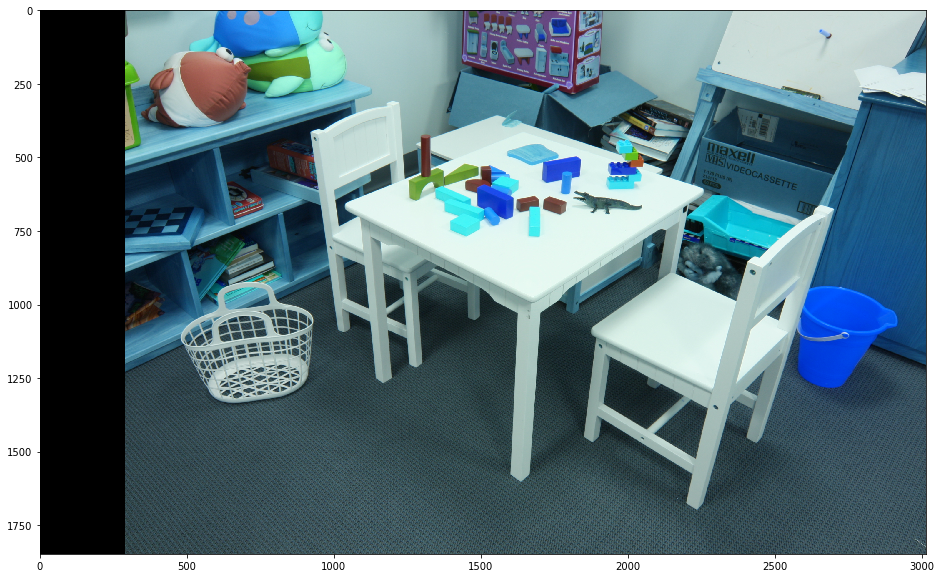

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(imgL)
plt.show()

## First test, using simple SGBM

computing disparity...


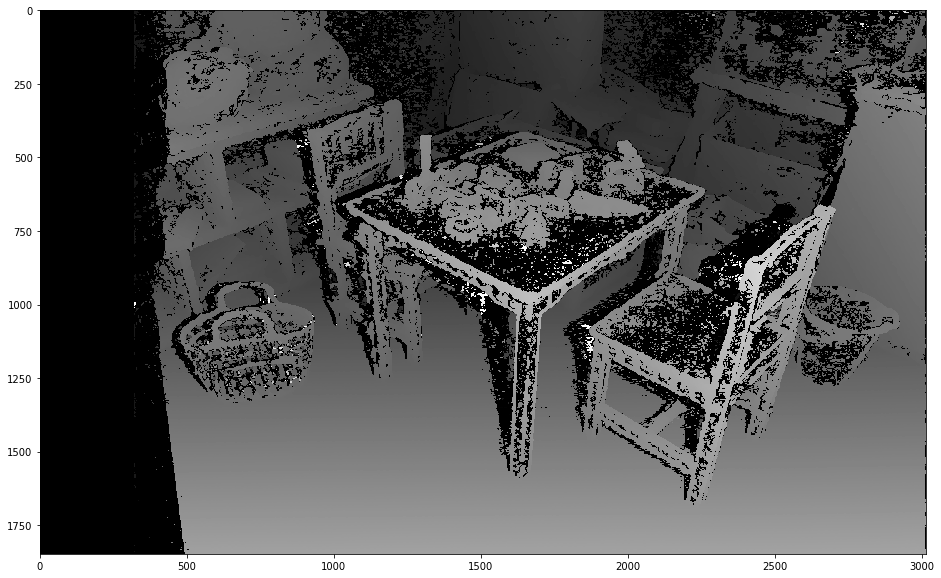

In [6]:
window_size = 5
min_disp = 0
num_disp = 320
stereo = cv.StereoSGBM_create(minDisparity = min_disp,
    numDisparities = num_disp,
    blockSize = 8,
    P1 = 8*3*window_size**2,
    P2 = 32*3*window_size**2,
    disp12MaxDiff = 1,
    uniquenessRatio = 15,
    speckleWindowSize = 0,
    speckleRange = 2,
    mode=cv.STEREO_SGBM_MODE_SGBM
)

print('computing disparity...')
disp = stereo.compute(imgL, imgR)
norm_disp = (disp-min_disp)/num_disp

fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(norm_disp,'gray')
plt.show()

## Second method using 'mode 3way' + disparity map post-filtering

In [7]:
window_size = 3
 
left_matcher = cv.StereoSGBM_create(
    minDisparity=0,
    numDisparities=288,             
    blockSize=5,
    P1=8 * 3 * window_size ** 2,    
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=2,
    mode=cv.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv.ximgproc.createRightMatcher(left_matcher)

In [8]:
print('computing disparity...')
displ = left_matcher.compute(imgL, imgR)
dispr = right_matcher.compute(imgR, imgL)
displ = np.int16(displ)
dispr = np.int16(dispr)

computing disparity...


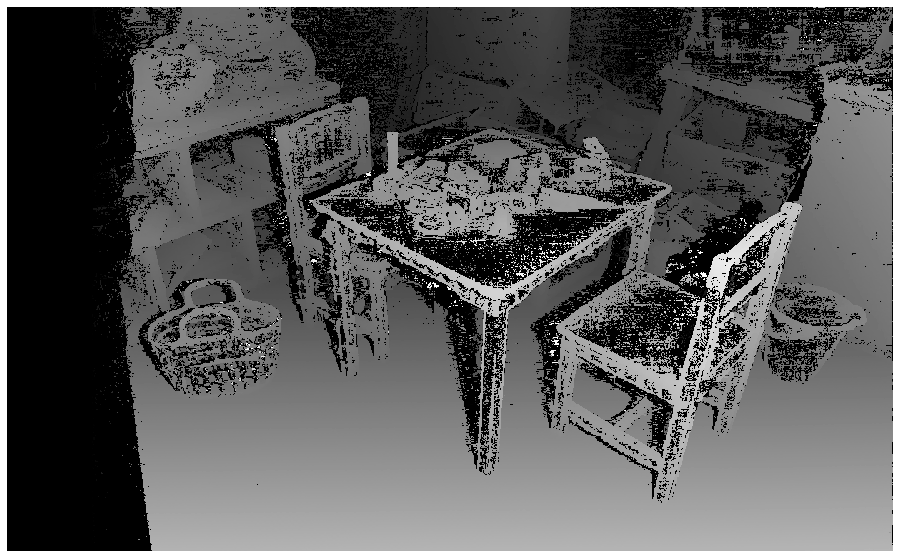

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')

plt.imshow(displ,'gray')
plt.show()

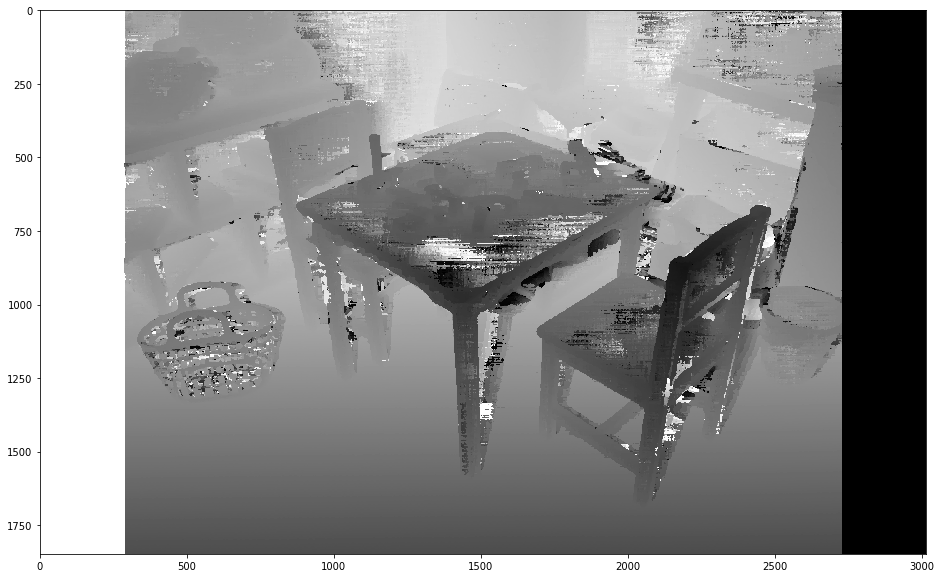

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(dispr,'gray')
plt.show()

In [11]:
##FILTER Parameters
# lmbda = 80000
# sigma = 1.2

### playtable
lmbda = 160000
sigma = 1.8

## jadeplant
# lmbda = 40000
# sigma = 1.0

wls_filter = cv.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

In [12]:
filteredImg = wls_filter.filter(displ, imgL, None, dispr)
filteredImg = filteredImg/16

In [13]:
# filteredImg = cv.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=22, norm_type=cv.NORM_MINMAX);
# filteredImg = np.uint8(filteredImg)

### removes padded columns

In [14]:
filteredImg = filteredImg[:,288:]
filteredImg

array([[110.5   , 110.25  , 110.125 , ...,  73.0625,  73.0625,  73.125 ],
       [110.5   , 110.25  , 110.125 , ...,  73.0625,  73.0625,  73.125 ],
       [110.5   , 110.25  , 110.125 , ...,  73.0625,  73.0625,  73.125 ],
       ...,
       [199.9375, 199.9375, 199.75  , ..., 202.375 , 202.375 , 202.    ],
       [199.9375, 199.9375, 199.75  , ..., 202.375 , 202.375 , 202.    ],
       [199.9375, 199.9375, 199.75  , ..., 202.375 , 202.375 , 202.    ]])

In [15]:
filteredImg.min(), filteredImg.max()

(9.5625, 263.5625)

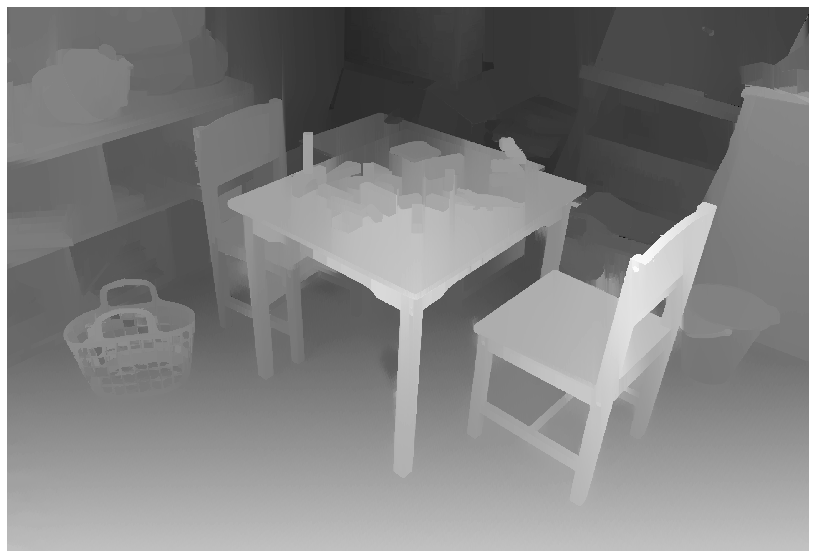

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')


# gray = cm.gray
# m = cm.ScalarMappable(cmap=gray)
# m.set_array([filteredImg.min(),filteredImg.max()])
# plt.colorbar(m, ax=ax)

plt.imshow(filteredImg, 'gray')
plt.show()

In [17]:
cv.imwrite("data/disparidade.pgm",filteredImg)

True

### Compares with ground truth

In [18]:
ground_truth = cv.imread('data/Middlebury/Playtable-perfect/disp0.pfm',-1)
#ground_truth = cv.imread('data/Middlebury/Jadeplant-perfect/disp0.pfm',-1)

ground_truth[ground_truth==np.inf] = 0
ground_truth = ground_truth / 256
ground_truth

array([[  0.      ,   0.      ,   0.      , ..., 119.73509 , 119.796585,
        119.858055],
       [  0.      ,   0.      ,   0.      , ..., 119.74281 , 119.80296 ,
        119.86268 ],
       [  0.      ,   0.      ,   0.      , ..., 119.74792 , 119.80675 ,
        119.866585],
       ...,
       [199.40001 , 199.42076 , 199.4202  , ..., 202.55986 , 202.53865 ,
        202.50607 ],
       [199.43805 , 199.43901 , 199.44347 , ..., 202.64267 , 202.60286 ,
        202.59074 ],
       [199.5131  , 199.52795 , 199.55107 , ..., 202.97833 , 202.93417 ,
        202.90785 ]], dtype=float32)

In [19]:
ground_truth.min(), ground_truth.max()

(0.0, 263.91113)

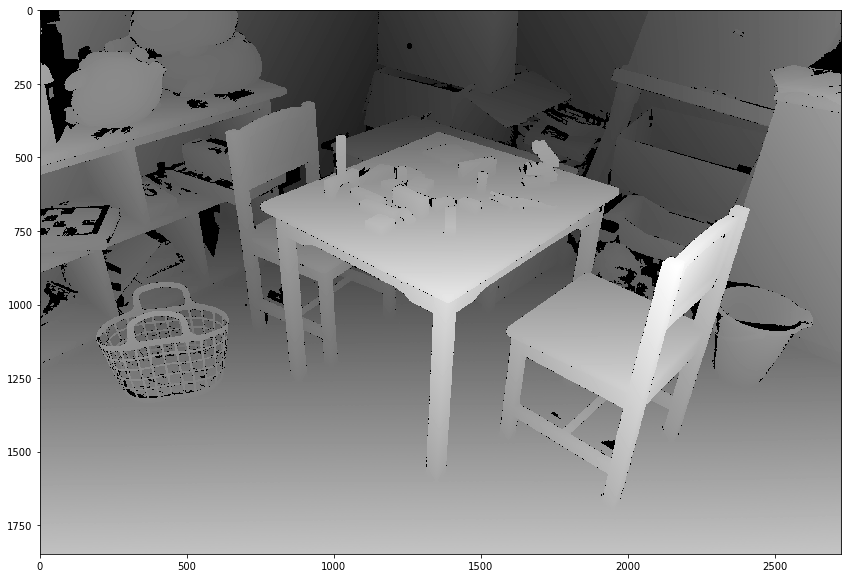

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.imshow(ground_truth, 'gray')
plt.show()

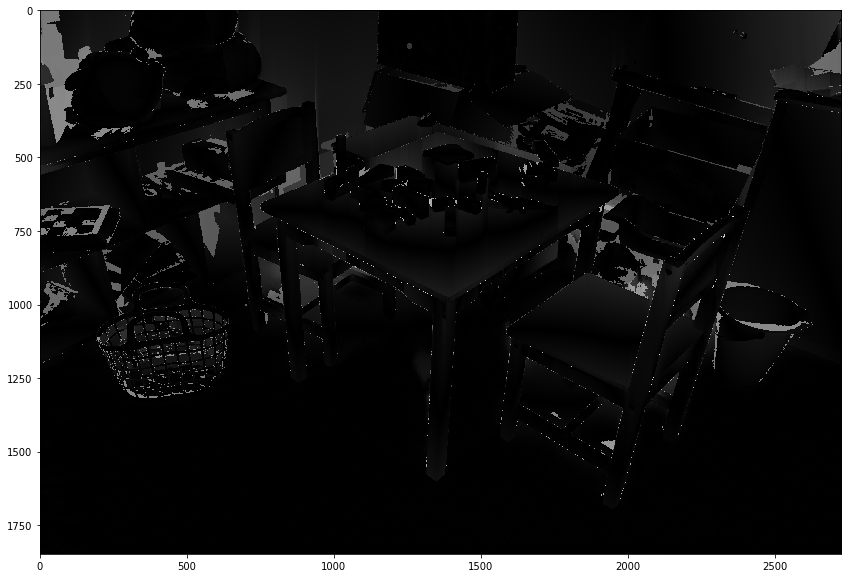

In [21]:
# ## scale the images first:
# filteredImg = cv.normalize(filteredImg, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)
# ground_truth = cv.normalize(ground_truth, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

diff = np.abs(filteredImg - ground_truth)

fig, ax = plt.subplots(figsize=(20, 10))

plt.imshow(diff, 'gray')
plt.show()

### Computes bad2.0

In [22]:
total_pixels = filteredImg.shape[0] * filteredImg.shape[1]
bad2 = np.count_nonzero(diff > 2) / total_pixels
bad2

0.4978436425297659

In [23]:
imgL.shape[0], imgL.shape[1]

(1848, 3012)

### Make depth map

In [24]:
# filteredImg = wls_filter.filter(displ, imgL, None, dispr)

In [25]:
# ### dividir por 16 pela saída do WLS
# filteredImg = filteredImg/16
# filteredImg

In [26]:
# def relu(m):
#     m[m < 0] = 0

# #relu(filteredImg)
# np.abs(filteredImg)
# #filteredImg

In [27]:
# filteredImg = filteredImg + 1

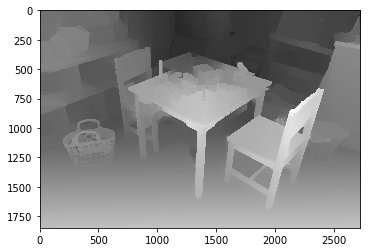

In [28]:
plt.imshow(filteredImg, 'gray')
plt.show()

In [29]:
# Z = baseline * f / (d + doffs)
filteredImg_2 = filteredImg + 100.279
filteredImg_2 = 193.006 * 2329.558 / filteredImg_2
# filteredImg_2 = filteredImg_2/1000

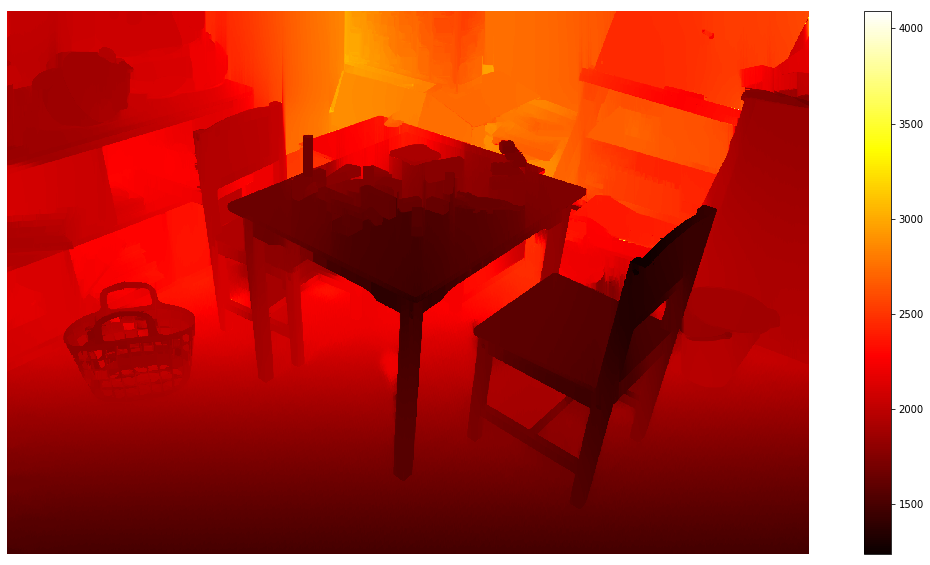

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.axis('off')

#filteredImg_2 = cv.normalize(src=filteredImg_2, dst=filteredImg_2, beta=0, alpha=254, norm_type=cv.NORM_MINMAX);
#filteredImg_2 = np.uint8(filteredImg_2)

hot = cm.hot
m = cm.ScalarMappable(cmap=hot)
m.set_array([filteredImg_2.min(),filteredImg_2.max()])
plt.colorbar(m, ax=ax)

plt.imshow(filteredImg_2, 'hot')
plt.show()

In [32]:
# fig.savefig("teste.png")

In [35]:
string = "[2329.558 0 1141.452; 0 2329.558 927.052; 0 0 1]"

'2329.558'